In [28]:
# # imports all helper classes/functions from utils.py, including other dependancies
# from utils import *

In [45]:
# Can also do "from utils_new import *" to get this class and other imports

import numpy as np
import math
import random

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

class Dataset():
    def __init__(self, filenames, apt_filename, id_filename, linker_filename):
        '''
        This Dataset class serves to process data for GFET data, for a single data well, including
        multiple devices per well, over the gate voltage sweeps for multiple concentrations.
        
        Parameters:
            filenames: list of filenames that contains gate voltage sweeps, each for a single concentration
            apt_filename: the filename of the voltage sweep for the devices with only the aptamer
        Returns:
            None

        Format of each file:
            First column: gate voltage
            All other columns: Drain-Source Resistance for a single device. Each row shows the resistance
            experienced by each device for the gate voltage of the 1st column.

        This assumes that all of the aptamer and linker data along with ALL concentrations share the same gate voltage steps.
        The initial dirac voltage does not have to have the same gate voltage steps.
        '''
        # initialize raw data and the data's basic features
        self.num_concs = len(filenames) # number of concentrations tested
        self.num_devices = 0 # number of devices in the well at hand, set super high to start it will get smaller later
        self.voltages = [] # list of the voltages we sweep over
        for conc in range(self.num_concs): # calcluate the voltages list, number of voltages, and number of devices
            raw_data = np.loadtxt('data/'+filenames[conc]).T # [:, [0, 1, 2, 3, 5]].T # [:, [0, 1, 2, 4]] # ONLY HERE BECAUSE WE WANT TO IGNORE FET 3
            if len(raw_data[0,:]) > len(self.voltages): 
                self.voltages = raw_data[0,:] # gets the biggest list of voltages to sweep over (some stop at 1.5V and others at 1.4V, we want 1.5)
            self.num_devices = raw_data.shape[0] - 1

        # builds resistance info
        self.apt_resistances = {} # dictionary of lists of aptemer resistances. {device_number: resistance_list}
        self.id_resistances = {} # dictionary of lists of initial dirac resistances. {device_number: resistance_list}
        self.linker_resistances = {}
        for dev_num in range(self.num_devices):
            raw_data_apt = np.loadtxt('data/'+apt_filename).T # [:, [0, 1, 2, 3, 5]].T  # ONLY HERE BECAUSE WE WANT TO IGNORE FET 4
            raw_data_id = np.loadtxt('data/'+id_filename).T # [:, [0, 1, 2, 3, 5]].T  # ONLY HERE BECAUSE WE WANT TO IGNORE FET 4
            raw_data_linker = np.loadtxt('data/'+linker_filename).T # [:, [0, 1, 2, 3, 5]].T  # ONLY HERE BECAUSE WE WANT TO IGNORE FET 4
            self.apt_resistances[dev_num] = raw_data_apt[dev_num+1]
            # print(dev_num+1)
            self.id_resistances[dev_num] = raw_data_id[dev_num+1]
            self.id_voltages = raw_data_id[0]
            self.linker_resistances[dev_num] = raw_data_linker[dev_num+1]
            # self.id_voltages = raw_data_id[0]
            
        self.resistances = {}  # dictionary of dictionary of resistance list. {concentration_num: {device_number: list_of_resistances}}
        for conc in range(self.num_concs):
            conc_data_dic = {}
            for dev_num in range(self.num_devices):
                raw_data = np.loadtxt('data/'+filenames[conc]).T # [:, [0, 1, 2, 3, 5]].T # [:, [0, 1, 2, 4]] # ONLY HERE BECAUSE WE WANT TO IGNORE FET 3
                conc_data_dic[dev_num] = raw_data[dev_num+1]
            self.resistances[conc] = conc_data_dic

        # builds resistance derivative info
        self.resistance_derivatives = {} # dictionary of dictionary of delta resistance list. {concentration_num: {device_number: list_of_resistance_changes}}
        for conc in range(self.num_concs):
            conc_resistance_derivative = {}
            for dev_num in range(self.num_devices): 
                conc_resistance_derivative[dev_num] = [self.resistances[conc][dev_num][i] - self.resistances[conc][dev_num][i+1] for i in range(len(self.resistances[conc][dev_num])-1)]
            self.resistance_derivatives[conc] = conc_resistance_derivative
        self.apt_resistance_derivatives = {} # dictionary of lists of aptemer delta resistance. {device_number: list_of_resistance_changes}
        self.id_resistance_derivatives = {} # dictionary that has the same structure as apt_resistance_derivatives, but for initial dirac sweep
        self.linker_resistance_derivatives = {}
        for dev_num in range(self.num_devices): 
            self.apt_resistance_derivatives[dev_num] = [self.apt_resistances[dev_num][i] - self.apt_resistances[dev_num][i+1] for i in range(len(self.apt_resistances[dev_num])-1)]
            self.id_resistance_derivatives[dev_num] = [self.id_resistances[dev_num][i] - self.id_resistances[dev_num][i+1] for i in range(len(self.id_resistances[dev_num])-1)]
            self.linker_resistance_derivatives[dev_num] = [self.linker_resistances[dev_num][i] - self.linker_resistances[dev_num][i+1] for i in range(len(self.linker_resistances[dev_num])-1)]

        
        # builds dirac voltage info
        self.apt_dirac_voltages = {} # dictionary of lists for dirac voltages for the aptemer. The list enumerates the concentrations. {device_number: dirac_voltage_list}
        self.id_dirac_voltages = {} # dictionary that has the same structure as apt_dirac_voltages, but for initial dirac sweep
        self.linker_dirac_voltages = {}
        for dev_num in range(self.num_devices):
            self.apt_dirac_voltages[dev_num] = self.voltages[np.argmax(self.apt_resistances[dev_num])]
            self.id_dirac_voltages[dev_num] = self.id_voltages[np.argmax(self.id_resistances[dev_num])]
            self.linker_dirac_voltages[dev_num] = self.voltages[np.argmax(self.linker_resistances[dev_num])]
        self.dirac_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of dirac voltages. x:concentration, y: device_number
        self.adj_dirac_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of dirac voltage shifts (adjusted). x:concentration, y: device_number
        for conc in range(self.num_concs):
            for dev_num in range(self.num_devices):
                self.dirac_voltages[conc,dev_num] = self.voltages[np.argmax(self.resistances[conc][dev_num])]
                self.adj_dirac_voltages[conc,dev_num] = self.voltages[np.argmax(self.resistances[conc][dev_num])] - self.apt_dirac_voltages[dev_num]

        # builds info about transconductance voltages, both pos and neg
        self.apt_pos_transc_voltages = {} # dictionary of lists for positive transconductance voltages for the aptemer. The list enumerates the concentrations. {device_number: pos_transc_v_list}
        self.apt_neg_transc_voltages = {}# dictionary of lists for negative transconductance voltages for the aptemer. The list enumerates the concentrations. {device_number: neg_transc_v_list}
        for dev_num in range(self.num_devices):
                self.apt_pos_transc_voltages[dev_num] = self.voltages[np.argmax(self.apt_resistance_derivatives[dev_num])]
                self.apt_neg_transc_voltages[dev_num] = self.voltages[np.argmin(self.apt_resistance_derivatives[dev_num])]
        self.pos_transc_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of positive transconductance voltages. x:concentration, y: device_number
        self.neg_transc_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of negative transconductance voltages. x:concentration, y: device_number
        self.adj_pos_transc_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of positive transconductance voltage shifts (adjusted). x:concentration, y: device_number
        self.adj_neg_transc_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of negative transconductance voltage shifts (adjusted). x:concentration, y: device_number
        for conc in range(self.num_concs):
            for dev_num in range(self.num_devices):
                self.pos_transc_voltages[conc, dev_num] = self.voltages[np.argmax(self.resistance_derivatives[conc][dev_num])]
                self.neg_transc_voltages[conc, dev_num] = self.voltages[np.argmin(self.resistance_derivatives[conc][dev_num])]
                self.adj_pos_transc_voltages[conc, dev_num] = self.voltages[np.argmax(self.resistance_derivatives[conc][dev_num])] - self.apt_pos_transc_voltages[dev_num]
                self.adj_neg_transc_voltages[conc, dev_num] = self.voltages[np.argmin(self.resistance_derivatives[conc][dev_num])] - self.apt_neg_transc_voltages[dev_num]

        # builds info about conductances
        self.apt_conductances = {dev_num: 1/self.apt_resistances[dev_num] for dev_num in range(self.num_devices)} # dictionary of lists of conductances for the aptamer readings. {device_number: conductance_list}
        self.id_conductances = {dev_num: 1/self.id_resistances[dev_num] for dev_num in range(self.num_devices)} # dictionary that has the same structure as apt_conductances, but for initial dirac sweep
        self.linker_conductances = {dev_num: 1/self.linker_resistances[dev_num] for dev_num in range(self.num_devices)}
        self.conductances = {} # dictionary of dictionaries of lists for conductance readings. {concentration: {device_number: conductance_list}}
        for conc in range(self.num_concs):
            self.conductances[conc] = [1 / self.resistances[conc][dev_num] for dev_num in range(self.num_devices)]

        # builds info about conductance derivatives
        self.conductance_derivatives = {} # dictionary of dictionary of delta conductance list. {concentration_num: {device_number: list_of_conductance_changes}}
        for conc in range(self.num_concs):
            conc_conductance_derivative = {}
            for dev_num in range(self.num_devices): 
                conc_conductance_derivative[dev_num] = [self.conductances[conc][dev_num][i] - self.conductances[conc][dev_num][i+1] for i in range(len(self.conductances[conc][dev_num])-1)]
            self.conductance_derivatives[conc] = conc_conductance_derivative
        self.apt_conductance_derivatives = {} # dictionary of lists of aptemer delta conductance. {device_number: list_of_conductance_changes}
        self.id_conductance_derivatives = {} # dictionary that has the same structure as apt_conductance_derivatives, but for initial dirac sweep
        self.linker_conductance_derivatives = {}
        for dev_num in range(self.num_devices): 
            self.apt_conductance_derivatives[dev_num] = [self.apt_conductances[dev_num][i] - self.apt_conductances[dev_num][i+1] for i in range(len(self.apt_conductances[dev_num])-1)]
            self.id_conductance_derivatives[dev_num] = [self.id_conductances[dev_num][i] - self.id_conductances[dev_num][i+1] for i in range(len(self.id_conductances[dev_num])-1)]
            self.linker_conductance_derivatives[dev_num] = [self.linker_conductances[dev_num][i] - self.linker_conductances[dev_num][i+1] for i in range(len(self.linker_conductances[dev_num])-1)]

        
    def conductance_shifts(self, voltage_to_track):
        '''
        Calculates the conductance shift over different concentrations, for a static gate voltage.

        Returns:
            2D array of conductance shifts, x: concentration, y: device_number
        Paramerers:
            voltage_to_track: gate voltage to fix, must be in the list self.voltages
        '''
        voltage_idx = np.abs(self.voltages - voltage_to_track).argmin() # index of voltage we want to track in self.voltages. The voltage can be an average of others so it may not be on the list

        # builds the 2D array of conductances at a voltage
        conductance_at_voltage = np.zeros((self.num_concs, self.num_devices)) # 2D array of conductances. x:concentration, y: device_number
        for conc in range(self.num_concs):
            for dev_num in range(self.num_devices):
                conductance_at_voltage[conc, dev_num] = self.conductances[conc][dev_num][voltage_idx]

        # builds the 2D array of the change in conductances at a voltage. This change is with respect to the aptamer conductance
        delta_conductance = np.zeros((self.num_concs, self.num_devices)) # 2D list tracking the change in conductances. x:concentration, y: device_number
        for dev_num in range(self.num_devices):
            delta_conductance[:,dev_num] = conductance_at_voltage[:,dev_num] - self.apt_conductances[dev_num][voltage_idx]

        return delta_conductance

    
    def normalize_2D_array(self, delta_Y, Y_0):
        Y_norm = np.zeros((self.num_concs, self.num_devices))
        for dev_num in range(self.num_devices):
            # G_norm[:,dev_num] = (G_0[dev_num] - delta_G[:,dev_num]) / G_0[dev_num]
            Y_norm[:,dev_num] = ((delta_Y[:,dev_num] - Y_0[dev_num]) / Y_0[dev_num] + 1) * 100
        return Y_norm

    
    def normalized_conductance_shifts(self, voltage_to_track):
        '''
        Calculates the normalized conductance shift over different concentrations, for a specific gate voltage.
        Normalization strategy is
                (I_0-I) / I_0 , 
        where I_0 is the aptamer coductance

        Returns:
            2D array of normalized conductance shifts, x: concentration, y: device_number
        Paramerers:
            voltage_to_track: gate voltage to fix, must be in the list self.voltages
        
        '''
        delta_G = self.conductance_shifts(voltage_to_track) # un-normalized conductance shift

        voltage_idx = np.abs(self.voltages - voltage_to_track).argmin() # index of voltage we want to track in self.voltages

        # builds G_0 list
        G_0 = {} # aptamer conductance, 
        for dev_num in range(self.num_devices):
            G_0[dev_num] = self.apt_conductances[dev_num][voltage_idx]

        # # builds G_norm array
        # G_norm = np.zeros((self.num_concs, self.num_devices))
        # for dev_num in range(self.num_devices):
        #     # G_norm[:,dev_num] = (G_0[dev_num] - delta_G[:,dev_num]) / G_0[dev_num]
        #     G_norm[:,dev_num] = (delta_G[:,dev_num] - G_0[dev_num]) / G_0[dev_num]

        # return G_norm
        return self.normalize_2D_array(delta_G, G_0)

    # def analysis(self, data_array_2D):
    #     '''
    #     Performs curve fitting of a data array vs concentration. For example, Dirac Voltage vs concentration, or conductance vs concentration.

    #     Returns:
    #         concentrations_list: The list of concentrations that corresponds to the data_array_flattened list. Neeed because the data_array_2D was flattened
    #         data_array_flattened: The flattened list from data_array_2D, needed because pyplot cannot plot 2D matrices.
    #         hill_coeffs = (A, K, n, b): Coefficients for hill curve fitted to distribution
    #         std_devs: The list, as long as the number of concentrations, for the standard deviations at each concentration
    #         S: sensitivity
    #         LOD: Limit of detection
    #         r2: r^2 value on how the hill curve fits the points
    #     Parameters:
    #         data_array_2D: 2D array of data we want to use. Must have x: concentration, y: device_number
    #     '''
    #     concentrations_list = np.repeat(range(self.num_concs), self.num_devices) # The list of concentrations that corresponds to the data_array_flattened list. Neeed because the data_array_2D is flattened
    #     data_array_flattened = data_array_2D.flatten() # The flattened list from data_array_2D, needed because pyplot cannot plot 2D matrices.
    #     hill_coeffs, c = curve_fit(hill_function, concentrations_list, data_array_flattened) # fits the datapoints to hill_function, the hill curve
    #     std_devs = [] # calculates the standard deviation for each concentration
    #     for i in range(self.num_concs):
    #         mu = hill_function(i, *hill_coeffs)
    #         val = np.sqrt(1/self.num_devices * sum([(mu - x_j)**2 for x_j in data_array_flattened[i*self.num_devices:i*(self.num_devices+1)]]))
    #         std_devs.append(val)
            
    #     # calculates slope, which is needed for LOD
    #     inf_point_x = inflection_point_hill_function(*hill_coeffs)
    #     S = derivative_hill_function(inf_point_x, *hill_coeffs)
    #     # print('inf point', inf_point_x)

    #     # calculates standard deviation at low concentration, which is needed for lOD 
    #     conc_to_take_std_dev = 3
    #     std_dev = np.std(data_array_flattened[conc_to_take_std_dev*self.num_devices:conc_to_take_std_dev*(self.num_devices+1)])

    #     # caluclates and prints LOD, LOQ, and dynamic range
    #     LOD = 3.3 * std_dev / S
    #     LOQ = 10 * std_dev / S
    #     # print(f'sensitivity: {S}') # :.4f}')
    #     print(f'LOD: {LOD} for decade, but for real:', str(10**(-18 + LOD)))
    #     # print(f'Theoetical dynamic range: {LOD} to {999999}')
    #     # print(f'Experimental dynamic range: {LOD} to 10^-9')
    #     # print(f'LOQ: {LOQ}')
    #     # print(f'Dynamic range: {LOD} to {LOQ}')

    #     # calculates r^2
    #     predicted_data = [hill_function(conc, *hill_coeffs) for conc in concentrations_list]
    #     r2 = r2_score(data_array_flattened, predicted_data)

    #     # calculates r^2 for only the linear region, 10^-18 - 10^-14
    #     predicted_data_linear = [hill_function(conc, *hill_coeffs) for conc in concentrations_list[:self.num_devices*5]]
    #     data_array_flattened_linear = data_array_flattened[:self.num_devices*5]
    #     r2_linear = r2_score(data_array_flattened_linear, predicted_data_linear)
        
    #     return concentrations_list, data_array_flattened, hill_coeffs, std_devs, S, LOD, r2, r2_linear



    def analysis(self, data_array_2D):
        '''
        Performs curve fitting of a data array vs concentration. For example, Dirac Voltage vs concentration, or conductance vs concentration.

        # Returns:
        #     concentrations_list: The list of concentrations that corresponds to the data_array_flattened list. Neeed because the data_array_2D was flattened
        #     data_array_flattened: The flattened list from data_array_2D, needed because pyplot cannot plot 2D matrices.
        #     hill_coeffs = (A, K, n, b): Coefficients for hill curve fitted to distribution
        #     std_devs: The list, as long as the number of concentrations, for the standard deviations at each concentration
        #     S: sensitivity
        #     LOD: Limit of detection
        #     r2: r^2 value on how the hill curve fits the points
        Parameters:
            data_array_2D: 2D array of data we want to use. Must have x: concentration, y: device_number
        '''
        hill_coeffs_array = np.zeros([self.num_devices, 4])
        for i in range(self.num_devices):
            # A, K, n, b
            hill_coeffs, c = curve_fit(hill_function, range(self.num_concs), data_array_2D[:,i].T, method='trf')
            hill_coeffs_array[i,:] = hill_coeffs

        predicted_data_array_2D = np.zeros([self.num_concs, self.num_devices])
        for dev_num in range(self.num_devices):
            hill_coeffs = hill_coeffs_array[dev_num]
            predicted_data_array_2D[:, dev_num] = np.array([hill_function(conc, *hill_coeffs) for conc in range(self.num_concs)]).T

        hill_coeffs_avg = np.mean(hill_coeffs_array, axis=0)
        # avg_predictions = np.array([hill_function(conc, *hill_coeffs_avg) for conc in range(self.num_concs)])
        avg_predictions = hill_function(range(self.num_concs), *hill_coeffs_avg)

                                   
        prediction_std_devs = []
        for conc in range(self.num_concs):
            mu = avg_predictions[conc]
            prediction_std_devs.append(math.sqrt(1/self.num_devices * sum([(data_array_2D[conc][dev_num] - mu)**2 for dev_num in range(self.num_devices)])))

        prediction_std_devs = np.array(prediction_std_devs)

        inf_points_x = np.array([inflection_point_hill_function(*hill_coeffs) for hill_coeffs in hill_coeffs_array])
        inf_points_x = np.array([max(0.5, x) for x in inf_points_x])
        Ss = np.array([derivative_hill_function(inf_points_x[i], *(hill_coeffs_array[i])) for i in range(self.num_devices)])
        S_mean = np.mean(Ss)
        S_std = np.std(Ss)
        # print(2222, inf_points_x, Ss)

        low_conc_to_take_std_dev = 3
        low_conc_std_devs = np.array([np.std((data_array_2D - predicted_data_array_2D)[low_conc_to_take_std_dev, dev_num]) for dev_num in range(self.num_devices)])
        LODs = 3.3 * low_conc_std_devs / Ss
        LOQs = 10 * low_conc_std_devs / Ss
        LOD_mean = np.mean(LODs)
        LOD_std = np.std(LODs)
        LOQ_mean = np.mean(LOQs)
        LOQ_std = np.std(LOQs)

        # calculates experimental range
        exp_range = []
        for dev_num in range(self.num_devices):
            hill_coeffs = hill_coeffs_array[dev_num]
            X_fit = np.linspace(0, self.num_concs-1, 100)
            Y_fit = hill_function(X_fit, *hill_coeffs)
            index_close_to_0 = min(range(len(Y_fit)), key=lambda i: abs(Y_fit[i]))
            exp_range.append(index_close_to_0 / 100 * (self.num_concs-1))
        exp_range = np.array(exp_range)
        exp_range_mean = np.mean(exp_range)
        exp_range_std = np.std(exp_range)
        

        # calculates r^2
        concentrations_list_flat = np.repeat(range(self.num_concs), self.num_devices) # The list of concentrations that corresponds to the data_array_flattened list. Neeed because the data_array_2D is flattened
        data_array_flat = data_array_2D.flatten() # The flattened list from data_array_2D, needed because pyplot cannot plot 2D matrices.
        predicted_data_flat = [hill_function(conc, *hill_coeffs_avg) for conc in concentrations_list_flat]
        r2 = r2_score(data_array_flat, predicted_data_flat)

        # calculates r^2 for only the linear region, 10^-18 - 10^-14
        predicted_data_flat_linear = [hill_function(conc, *hill_coeffs_avg) for conc in concentrations_list_flat[:self.num_devices*5]]
        data_array_flat_linear = data_array_flat[:self.num_devices*5]
        r2_linear = r2_score(data_array_flat_linear, predicted_data_flat_linear)

        return data_array_2D, hill_coeffs_array, prediction_std_devs, S_mean, S_std, LOD_mean, LOD_std, exp_range_mean, exp_range_std, r2, r2_linear

    def sweep_dirac_analysis(self):
        '''
        Analysis for dirac voltage shift
        '''
        return self.analysis(self.adj_dirac_voltages)

    def sweep_dirac_analysis_normalized(self):
        '''
        Analysis for normalized dirac voltage shift
        '''
        return self.analysis(self.normalize_2D_array(self.adj_dirac_voltages, self.apt_dirac_voltages))

    def sweep_pos_transconductance_analysis(self):
        return self.analysis(self.adj_pos_transc_voltages)

    def sweep_pos_transconductance_analysis_normalized(self):
        return self.analysis(self.normalize_2D_array(self.adj_pos_transc_voltages, self.apt_pos_transc_voltages))

    def sweep_neg_transconductance_analysis(self):
        return self.analysis(self.adj_neg_transc_voltages)

    def sweep_neg_transconductance_analysis_normalized(self):
        return self.analysis(self.normalize_2D_array(self.adj_neg_transc_voltages, self.apt_neg_transc_voltages))
        
    def static_dirac_analysis(self):
        avg_apt_dirac_voltage = np.mean(list(self.apt_dirac_voltages.values()))   
        return self.analysis(self.conductance_shifts(avg_apt_dirac_voltage))

    def static_dirac_analysis_normalized(self):
        avg_apt_dirac_voltage = np.mean(list(self.apt_dirac_voltages.values()))   
        return self.analysis(self.normalized_conductance_shifts(avg_apt_dirac_voltage))
    
    def static_pos_transc_conduc_analysis(self):
        '''
        Analysis for transconductance conductance, at the mean of the positive aptamer transconductance point
        '''
        avg_pos_apt_transc_voltage = np.mean(list(self.apt_pos_transc_voltages.values()))        
        return self.analysis(self.conductance_shifts(avg_pos_apt_transc_voltage))

    def static_pos_transc_conduc_analysis_normalized(self):
        '''
        Analysis for normalzied transconductance conductance, at the mean of the positive aptamer transconductance point
        '''
        avg_pos_apt_transc_voltage = np.mean(list(self.apt_pos_transc_voltages.values()))
        return self.analysis(self.normalized_conductance_shifts(avg_pos_apt_transc_voltage))
        
    def static_neg_transc_conduc_analysis(self):
        '''
        Analysis for transconductance conductance, at the mean of the negative aptamer transconductance point
        '''
        avg_neg_apt_transc_voltage = np.mean(list(self.apt_neg_transc_voltages.values()))        
        return self.analysis(self.conductance_shifts(avg_neg_apt_transc_voltage))

    def static_neg_transc_conduc_analysis_normalized(self):
        '''
        Analysis for normalized transconductance conductance, at the mean of the negative aptamer transconductance point
        '''
        avg_neg_apt_transc_voltage = np.mean(list(self.apt_neg_transc_voltages.values()))
        return self.analysis(self.normalized_conductance_shifts(avg_neg_apt_transc_voltage))

def hill_function(x, A, K, n, b):
    '''
    Hill curve
    Returns the value at input x, given coefficients
    '''
    # if K < 0: K=random.uniform(0, 5) # setting arbitrary K value if K<0 because this throws error. Done because polyfit
    return A * (x**n) / (K**n + x**n) + b

def derivative_hill_function(x, A, K, n, b):
    '''
    Derivative of the hill curve
    Returns the value at input x, given coefficients
    '''
    return A * n * K**n * (x**(n-1)) / (K**n + x**n)**2

def inflection_point_hill_function(A, K, n, b):
    '''
    The inflection point of the hill curve
    Returns the inflection point, given coefficients
    '''
    return max(0, K* ((n-1)/(n+1))**(1/n))

def format_with_e(x, pos):
    '''
    Used in pyplot, for formatting the y-axis so that the numbers use e notation, not leading 0's or e's above the y-axis
    '''
    return f'{x:.1e}' if not x==0 else 0

C:\Users\joeyl\AppData\Local\Temp\ipykernel_3620\1726266503.py:403: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


S: 11.913467358801554, uncertainty: 0.6123128571079094
LOD: 1e-18, uncertainty: 1.3405382816593311e-18
exp range: 1.5135612484362071e-18, uncertainty: 1.3405382816593311e-18
r2: 0.9089734056900789
r2 linear: 0.9618659743707623


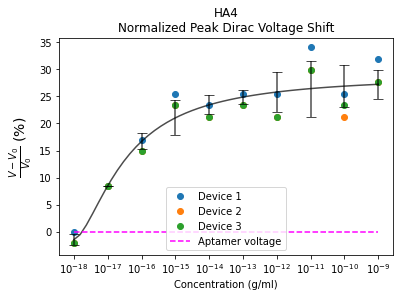

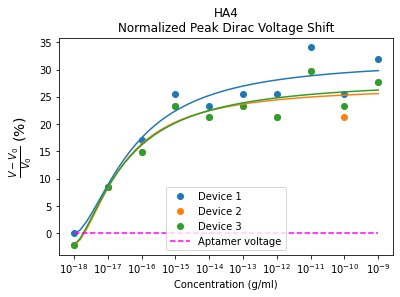

C:\Users\joeyl\AppData\Local\Temp\ipykernel_3620\1726266503.py:403: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_3620\1726266503.py:417: RuntimeWarning: invalid value encountered in scalar power
  return max(0, K* ((n-1)/(n+1))**(1/n))


S: 10.492651015199185, uncertainty: 0.17831748771182862
LOD: 1e-18, uncertainty: 1e-18
exp range: 2.630267991895392e-18, uncertainty: 1.2157738942449705e-18
r2: 0.9712771462102884
r2 linear: 0.9639467991349654


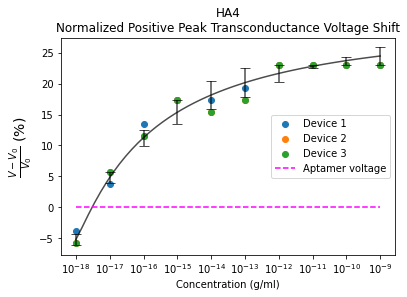

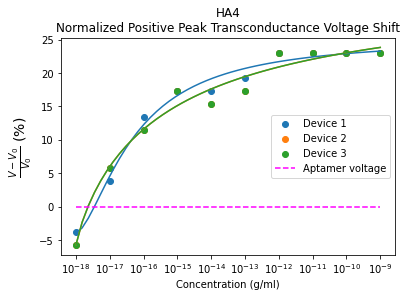

C:\Users\joeyl\AppData\Local\Temp\ipykernel_3620\1726266503.py:403: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_3620\1726266503.py:403: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_3620\1726266503.py:403: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


S: 16.36788151431563, uncertainty: 3.6084614838673414
LOD: 1e-18, uncertainty: 1e-18
exp range: 2.818382931264449e-18, uncertainty: 1.797042884594167e-18
r2: 0.607413136094288
r2 linear: 0.9480728631384086


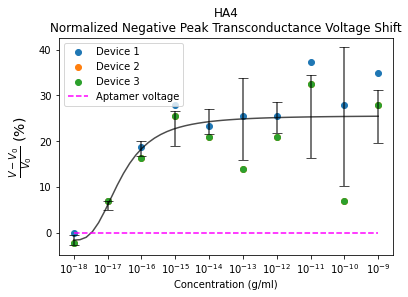

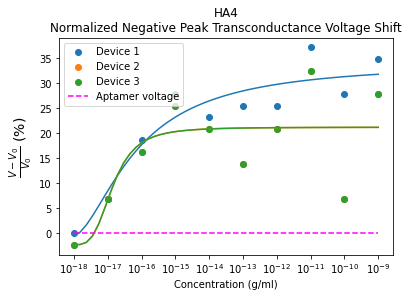

C:\Users\joeyl\AppData\Local\Temp\ipykernel_3620\1726266503.py:403: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


S: 8.364317017351843e-22, uncertainty: 1.1821288921292498e-21
LOD: 1e-18, uncertainty: 1e-18
exp range: 1e-18, uncertainty: 1e-18
r2: -0.6395070490854002
r2 linear: -0.26639388152107135


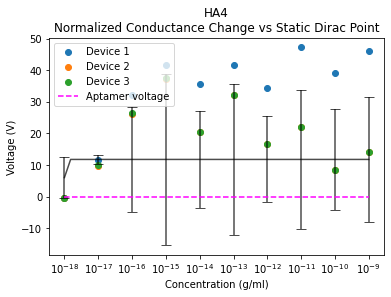

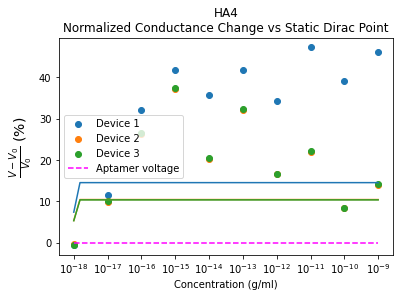

C:\Users\joeyl\AppData\Local\Temp\ipykernel_3620\1726266503.py:403: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


S: 0.8515844926433709, uncertainty: 1.2043223390028663
LOD: 1e-18, uncertainty: 1e-18
exp range: 1.584893192461111e-17, uncertainty: 4.978015847472828e-17
r2: -0.1780741881608674
r2 linear: -0.1580555652419804


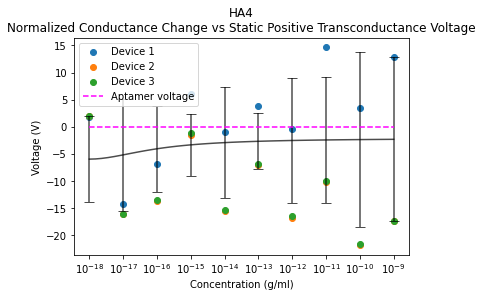

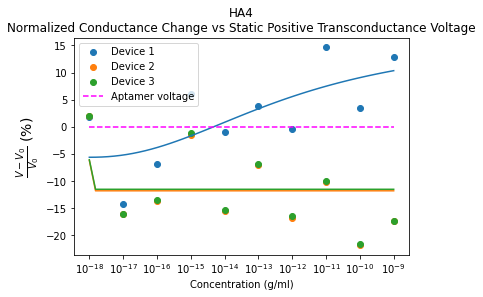

C:\Users\joeyl\AppData\Local\Temp\ipykernel_3620\1726266503.py:403: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


S: 1.0962132808412137e-20, uncertainty: 9.380645087709141e-21
LOD: 1e-18, uncertainty: 1e-18
exp range: 1e-18, uncertainty: 1e-18
r2: -0.6774325675159247
r2 linear: -0.2812372308234419


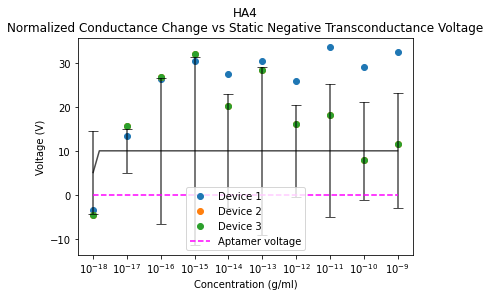

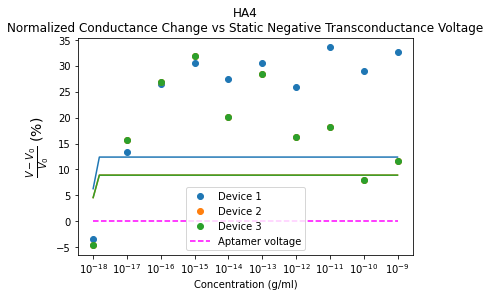

In [46]:
# for HA4, well 4

# filenames to inlude for each concentration
filenames = ['BCdata_B48C13_HA4_1ag.txt', 
             'BCdata_B48C13_HA4_10ag.txt', 
             'BCdata_B48C13_HA4_100ag.txt', 
             'BCdata_B48C13_HA4_1fg.txt', 
             'BCdata_B48C13_HA4_10fg.txt', 
             'BCdata_B48C13_HA4_100fg.txt', 
             'BCdata_B48C13_HA4_1pg.txt', 
             'BCdata_B48C13_HA4_10pg.txt', 
             'BCdata_B48C13_HA4_100pg.txt', 
             'BCdata_B48C13_HA4_1ng.txt']

filename_aptamer = 'BCdata_B48C13_HA4_aptamers.txt'
filename_id = 'BCdata_B48C13_HA4_initialDirac.txt'
filename_linker = 'BCdata_B48C13_HA4_linker.txt'

dataset = Dataset(filenames, filename_aptamer, filename_id, filename_linker)
concs = range(dataset.num_concs)


# Dirac vaoltage sweep
data_array_2D, hill_coeffs_array, prediction_std_devs, S_mean, S_std, LOD_mean, LOD_std, exp_range_mean, exp_range_std, r2, r2_linear = dataset.sweep_dirac_analysis_normalized()
print(f'S: {S_mean}, uncertainty: {S_std}')
print(f'LOD: {str(10**(-18 + LOD_mean))}, uncertainty: {str(10**(-18 + exp_range_std))}')
print(f'exp range: {str(10**(-18 + exp_range_mean))}, uncertainty: {str(10**(-18 + exp_range_std))}')
print(f'r2: {r2}')
print(f'r2 linear: {r2_linear}')
X_fit = np.linspace(min(concs), max(concs), 50)
Y_fit = hill_function(X_fit, *np.mean(hill_coeffs_array, axis=0))
plt.plot(X_fit, Y_fit, color = 'black', alpha=0.7)
plt.errorbar(concs, hill_function(concs, *np.mean(hill_coeffs_array, axis=0)), yerr=prediction_std_devs, ecolor='black', fmt='None', capsize=5, alpha=0.7)
for dev_num in range(data_array_2D.shape[1]):
    plt.scatter(concs, data_array_2D[:, dev_num], marker='o', label=f'Device {dev_num+1}')
plt.plot([0,9], [0,0], color='magenta', linestyle='--', label='Aptamer voltage')
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.legend()
plt.title('HA4\nNormalized Peak Dirac Voltage Shift')
plt.xlabel("Concentration (g/ml)")
plt.ylabel(rf'$\frac{{V-V_0}}{{V_0}}$ (%)', fontsize=14)
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.show()
plt.close()

for dev_num in range(dataset.num_devices):
    plt.scatter(concs, data_array_2D[:,dev_num], marker='o', label=f'Device {dev_num+1}')
    hill_coeffs = hill_coeffs_array[dev_num]
    Y_fit = hill_function(X_fit, *hill_coeffs)
    plt.plot(X_fit, Y_fit)
plt.plot([0,9], [0,0], color='magenta', linestyle='--', label='Aptamer voltage')
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.legend()
plt.title('HA4\nNormalized Peak Dirac Voltage Shift')
plt.xlabel("Concentration (g/ml)")
plt.ylabel(rf'$\frac{{V-V_0}}{{V_0}}$ (%)', fontsize=14)
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.show()
plt.close()



# Positive Transconductance Voltage sweep
data_array_2D, hill_coeffs_array, prediction_std_devs, S_mean, S_std, LOD_mean, LOD_std, exp_range_mean, exp_range_std, r2, r2_linear = dataset.sweep_pos_transconductance_analysis_normalized()
print(f'S: {S_mean}, uncertainty: {S_std}')
print(f'LOD: {str(10**(-18 + LOD_mean))}, uncertainty: {str(10**(-18 + LOD_std))}')
print(f'exp range: {str(10**(-18 + exp_range_mean))}, uncertainty: {str(10**(-18 + exp_range_std))}')
print(f'r2: {r2}')
print(f'r2 linear: {r2_linear}')
for dev_num in range(data_array_2D.shape[1]):
    plt.scatter(concs, data_array_2D[:, dev_num], marker='o', label=f'Device {dev_num+1}')
X_fit = np.linspace(min(concs), max(concs), 50)
Y_fit = hill_function(X_fit, *np.mean(hill_coeffs_array, axis=0))
plt.plot(X_fit, Y_fit, color = 'black', alpha=0.7)
plt.errorbar(concs, hill_function(concs, *np.mean(hill_coeffs_array, axis=0)), yerr=prediction_std_devs, ecolor='black', fmt='None', capsize=5, alpha=0.7)
plt.plot([0,9], [0,0], color='magenta', linestyle='--', label='Aptamer voltage')
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.legend()
plt.title('HA4\nNormalized Positive Peak Transconductance Voltage Shift')
plt.xlabel("Concentration (g/ml)")
plt.ylabel(rf'$\frac{{V-V_0}}{{V_0}}$ (%)', fontsize=14)
plt.show()
plt.close()

for dev_num in range(dataset.num_devices):
    plt.scatter(concs, data_array_2D[:,dev_num], marker='o', label=f'Device {dev_num+1}')
    hill_coeffs = hill_coeffs_array[dev_num]
    Y_fit = hill_function(X_fit, *hill_coeffs)
    plt.plot(X_fit, Y_fit)
plt.plot([0,9], [0,0], color='magenta', linestyle='--', label='Aptamer voltage')
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.legend()
plt.title('HA4\nNormalized Positive Peak Transconductance Voltage Shift')
plt.xlabel("Concentration (g/ml)")
plt.ylabel(rf'$\frac{{V-V_0}}{{V_0}}$ (%)', fontsize=14)
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.show()
plt.close()




# Negative Transconductance Voltage sweep
data_array_2D, hill_coeffs_array, prediction_std_devs, S_mean, S_std, LOD_mean, LOD_std, exp_range_mean, exp_range_std, r2, r2_linear = dataset.sweep_neg_transconductance_analysis_normalized()
print(f'S: {S_mean}, uncertainty: {S_std}')
print(f'LOD: {str(10**(-18 + LOD_mean))}, uncertainty: {str(10**(-18 + LOD_std))}')
print(f'exp range: {str(10**(-18 + exp_range_mean))}, uncertainty: {str(10**(-18 + exp_range_std))}')
print(f'r2: {r2}')
print(f'r2 linear: {r2_linear}')
for dev_num in range(data_array_2D.shape[1]):
    plt.scatter(concs, data_array_2D[:, dev_num], marker='o', label=f'Device {dev_num+1}')
X_fit = np.linspace(min(concs), max(concs), 50)
Y_fit = hill_function(X_fit, *np.mean(hill_coeffs_array, axis=0))
plt.plot(X_fit, Y_fit, color = 'black', alpha=0.7)
plt.errorbar(concs, hill_function(concs, *np.mean(hill_coeffs_array, axis=0)), yerr=prediction_std_devs, ecolor='black', fmt='None', capsize=5, alpha=0.7)
plt.plot([0,9], [0,0], color='magenta', linestyle='--', label='Aptamer voltage')
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.legend()
plt.title('HA4\nNormalized Negative Peak Transconductance Voltage Shift')
plt.xlabel("Concentration (g/ml)")
plt.ylabel(rf'$\frac{{V-V_0}}{{V_0}}$ (%)', fontsize=14)
plt.show()
plt.close()

for dev_num in range(dataset.num_devices):
    plt.scatter(concs, data_array_2D[:,dev_num], marker='o', label=f'Device {dev_num+1}')
    hill_coeffs = hill_coeffs_array[dev_num]
    Y_fit = hill_function(X_fit, *hill_coeffs)
    plt.plot(X_fit, Y_fit)
plt.plot([0,9], [0,0], color='magenta', linestyle='--', label='Aptamer voltage')
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.legend()
plt.title('HA4\nNormalized Negative Peak Transconductance Voltage Shift')
plt.xlabel("Concentration (g/ml)")
plt.ylabel(rf'$\frac{{V-V_0}}{{V_0}}$ (%)', fontsize=14)
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.show()
plt.close()





# Dirac vaoltage sweep
data_array_2D, hill_coeffs_array, prediction_std_devs, S_mean, S_std, LOD_mean, LOD_std, exp_range_mean, exp_range_std, r2, r2_linear = dataset.static_dirac_analysis_normalized()
print(f'S: {S_mean}, uncertainty: {S_std}')
print(f'LOD: {str(10**(-18 + LOD_mean))}, uncertainty: {str(10**(-18 + exp_range_std))}')
print(f'exp range: {str(10**(-18 + exp_range_mean))}, uncertainty: {str(10**(-18 + exp_range_std))}')
print(f'r2: {r2}')
print(f'r2 linear: {r2_linear}')
X_fit = np.linspace(min(concs), max(concs), 50)
Y_fit = hill_function(X_fit, *np.mean(hill_coeffs_array, axis=0))
plt.plot(X_fit, Y_fit, color = 'black', alpha=0.7)
plt.errorbar(concs, hill_function(concs, *np.mean(hill_coeffs_array, axis=0)), yerr=prediction_std_devs, ecolor='black', fmt='None', capsize=5, alpha=0.7)
for dev_num in range(data_array_2D.shape[1]):
    plt.scatter(concs, data_array_2D[:, dev_num], marker='o', label=f'Device {dev_num+1}')
plt.plot([0,9], [0,0], color='magenta', linestyle='--', label='Aptamer voltage')
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.legend()
plt.title('HA4\nNormalized Conductance Change vs Static Dirac Point')
plt.xlabel("Concentration (g/ml)")
plt.ylabel('Voltage (V)') # "Dirac Shift (V)")
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.show()
plt.close()

for dev_num in range(dataset.num_devices):
    plt.scatter(concs, data_array_2D[:,dev_num], marker='o', label=f'Device {dev_num+1}')
    hill_coeffs = hill_coeffs_array[dev_num]
    Y_fit = hill_function(X_fit, *hill_coeffs)
    plt.plot(X_fit, Y_fit)
plt.plot([0,9], [0,0], color='magenta', linestyle='--', label='Aptamer voltage')
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.legend()
plt.title('HA4\nNormalized Conductance Change vs Static Dirac Point')
plt.xlabel("Concentration (g/ml)")
plt.ylabel(rf'$\frac{{V-V_0}}{{V_0}}$ (%)', fontsize=14)
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.show()
plt.close()





# Positive Transconductance Voltage sweep
data_array_2D, hill_coeffs_array, prediction_std_devs, S_mean, S_std, LOD_mean, LOD_std, exp_range_mean, exp_range_std, r2, r2_linear = dataset.static_pos_transc_conduc_analysis_normalized()
print(f'S: {S_mean}, uncertainty: {S_std}')
print(f'LOD: {str(10**(-18 + LOD_mean))}, uncertainty: {str(10**(-18 + LOD_std))}')
print(f'exp range: {str(10**(-18 + exp_range_mean))}, uncertainty: {str(10**(-18 + exp_range_std))}')
print(f'r2: {r2}')
print(f'r2 linear: {r2_linear}')
for dev_num in range(data_array_2D.shape[1]):
    plt.scatter(concs, data_array_2D[:, dev_num], marker='o', label=f'Device {dev_num+1}')
X_fit = np.linspace(min(concs), max(concs), 50)
Y_fit = hill_function(X_fit, *np.mean(hill_coeffs_array, axis=0))
plt.plot(X_fit, Y_fit, color = 'black', alpha=0.7)
plt.errorbar(concs, hill_function(concs, *np.mean(hill_coeffs_array, axis=0)), yerr=prediction_std_devs, ecolor='black', fmt='None', capsize=5, alpha=0.7)
plt.plot([0,9], [0,0], color='magenta', linestyle='--', label='Aptamer voltage')
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.legend()
plt.title('HA4\nNormalized Conductance Change vs Static Positive Transconductance Voltage')
plt.xlabel("Concentration (g/ml)")
plt.ylabel('Voltage (V)') # "Dirac Shift (V)")
plt.show()
plt.close()

for dev_num in range(dataset.num_devices):
    plt.scatter(concs, data_array_2D[:,dev_num], marker='o', label=f'Device {dev_num+1}')
    hill_coeffs = hill_coeffs_array[dev_num]
    Y_fit = hill_function(X_fit, *hill_coeffs)
    plt.plot(X_fit, Y_fit)
plt.plot([0,9], [0,0], color='magenta', linestyle='--', label='Aptamer voltage')
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.legend()
plt.title('HA4\nNormalized Conductance Change vs Static Positive Transconductance Voltage')
plt.xlabel("Concentration (g/ml)")
plt.ylabel(rf'$\frac{{V-V_0}}{{V_0}}$ (%)', fontsize=14)
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.show()
plt.close()






# Negative Transconductance Voltage sweep
data_array_2D, hill_coeffs_array, prediction_std_devs, S_mean, S_std, LOD_mean, LOD_std, exp_range_mean, exp_range_std, r2, r2_linear = dataset.static_neg_transc_conduc_analysis_normalized()
print(f'S: {S_mean}, uncertainty: {S_std}')
print(f'LOD: {str(10**(-18 + LOD_mean))}, uncertainty: {str(10**(-18 + LOD_std))}')
print(f'exp range: {str(10**(-18 + exp_range_mean))}, uncertainty: {str(10**(-18 + exp_range_std))}')
print(f'r2: {r2}')
print(f'r2 linear: {r2_linear}')
for dev_num in range(data_array_2D.shape[1]):
    plt.scatter(concs, data_array_2D[:, dev_num], marker='o', label=f'Device {dev_num+1}')
X_fit = np.linspace(min(concs), max(concs), 50)
Y_fit = hill_function(X_fit, *np.mean(hill_coeffs_array, axis=0))
plt.plot(X_fit, Y_fit, color = 'black', alpha=0.7)
plt.errorbar(concs, hill_function(concs, *np.mean(hill_coeffs_array, axis=0)), yerr=prediction_std_devs, ecolor='black', fmt='None', capsize=5, alpha=0.7)
plt.plot([0,9], [0,0], color='magenta', linestyle='--', label='Aptamer voltage')
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.legend()
plt.title('HA4\nNormalized Conductance Change vs Static Negative Transconductance Voltage')
plt.xlabel("Concentration (g/ml)")
plt.ylabel('Voltage (V)') # "Dirac Shift (V)")
plt.show()
plt.close()

for dev_num in range(dataset.num_devices):
    plt.scatter(concs, data_array_2D[:,dev_num], marker='o', label=f'Device {dev_num+1}')
    hill_coeffs = hill_coeffs_array[dev_num]
    Y_fit = hill_function(X_fit, *hill_coeffs)
    plt.plot(X_fit, Y_fit)
plt.plot([0,9], [0,0], color='magenta', linestyle='--', label='Aptamer voltage')
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.legend()
plt.title('HA4\nNormalized Conductance Change vs Static Negative Transconductance Voltage')
plt.xlabel("Concentration (g/ml)")
plt.ylabel(rf'$\frac{{V-V_0}}{{V_0}}$ (%)', fontsize=14)
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.show()
plt.close()

LOD: 0.2800240535886163 for decade, but for real: 1.905566255655783e-18
S: 0.11110723515886183
LOD: 0.2800240535886163
r2: 0.9089789693882483
r2 linear: 0.9618047242920531


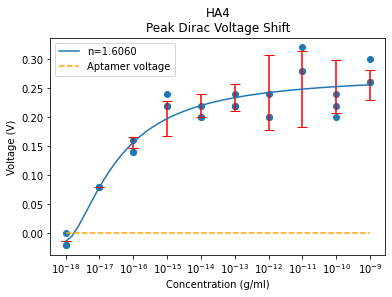

LOD: 0.280024043115379 for decade, but for real: 1.9055662097020656e-18
S: 0.11819919076000704
LOD: 0.280024043115379
r2: 0.9089789693883807
r2 linear: 0.9618047283551402


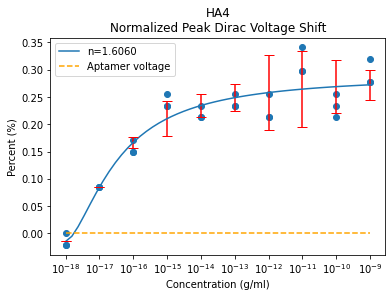

LOD: 0.0 for decade, but for real: 1e-18
S: 0.13133522025371722
LOD: 0.0
r2: 0.9744872255002222
r2 linear: 0.9684872856963501


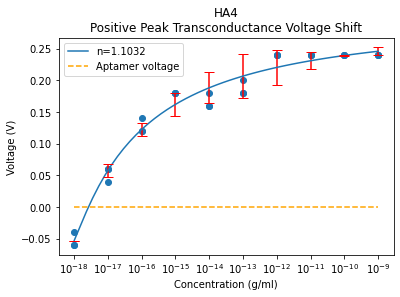

LOD: 0.0 for decade, but for real: 1e-18
S: 0.12628385726749136
LOD: 0.0
r2: 0.9744872255002129
r2 linear: 0.9684872857079178


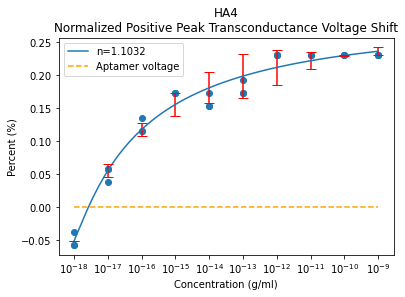

LOD: 0.23064445649169202 for decade, but for real: 1.7007655739350652e-18
S: 0.13489462892566342
LOD: 0.23064445649169202
r2: 0.615205206837304
r2 linear: 0.9466604828687405


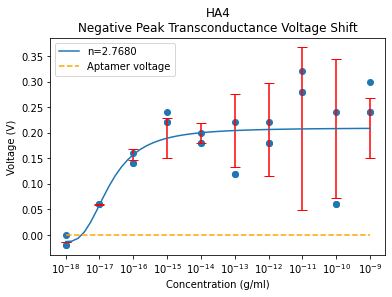

LOD: 0.23064455280635618 for decade, but for real: 1.7007659511184993e-18
S: 0.1568541541803829
LOD: 0.23064455280635618
r2: 0.615205206835167
r2 linear: 0.9466604645236725


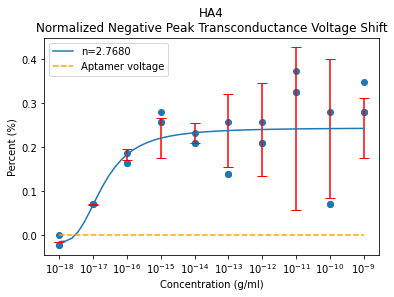

C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


LOD: 0.2040913134683486 for decade, but for real: 1.5998943822958212e-18
S: 0.001447092137042747
LOD: 0.2040913134683486
r2: 0.4230861429377646
r2 linear: 0.5850155378999393


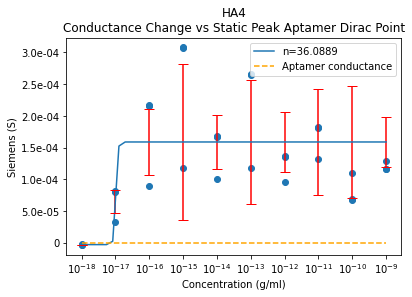

C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


LOD: 0.04166039250574106 for decade, but for real: 1.1006782698701635e-18
S: 1.6182087107003245
LOD: 0.04166039250574106
r2: 0.4660952455991083
r2 linear: 0.8187372930218377


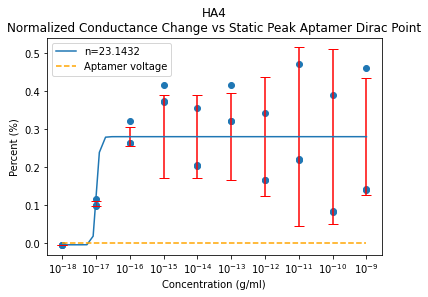

C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:336: RuntimeWarning: invalid value encountered in scalar power
  return K* ((n-1)/(n+1))**(1/n)


LOD: nan for decade, but for real: nan
S: nan
LOD: nan
r2: 0.13117965724224423
r2 linear: 0.27391177110500364


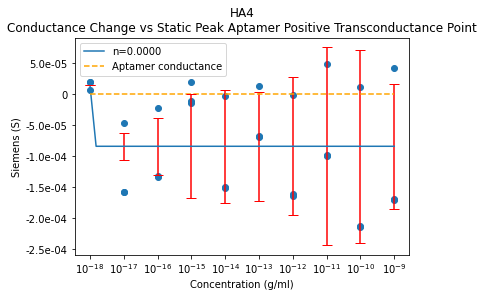

C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:336: RuntimeWarning: invalid value encountered in scalar power
  return K* ((n-1)/(n+1))**(1/n)


LOD: nan for decade, but for real: nan
S: nan
LOD: nan
r2: 0.09229301677554325
r2 linear: 0.28906893266436473


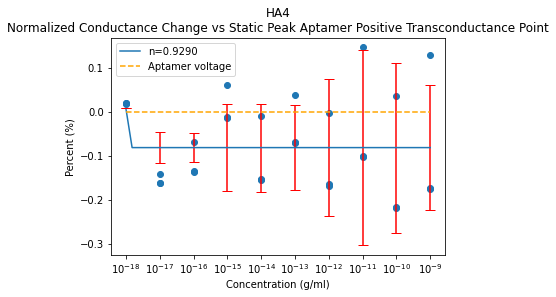

C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:336: RuntimeWarning: invalid value encountered in scalar power
  return K* ((n-1)/(n+1))**(1/n)


LOD: nan for decade, but for real: nan
S: nan
LOD: nan
r2: 0.39071077750526395
r2 linear: 0.5244366113951331


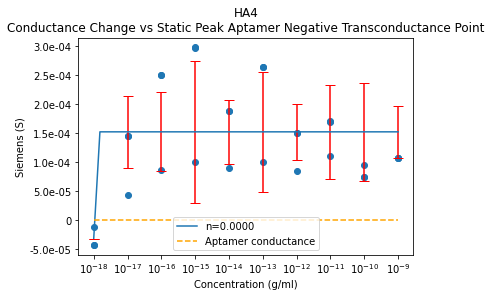

C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:322: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


LOD: 0.010858104456370123 for decade, but for real: 1.025316873260511e-18
S: 2.1098375790380857
LOD: 0.010858104456370123
r2: 0.5801721955084636
r2 linear: 0.882703777510023


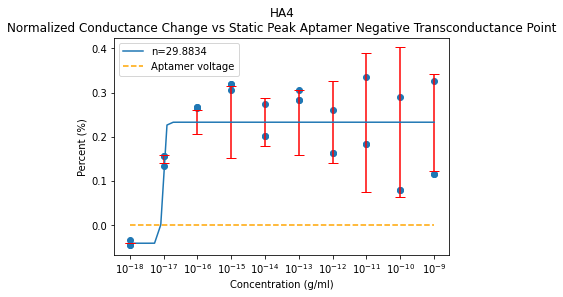

In [4]:
# # for HA4, well 4

# # filenames to inlude for each concentration
# filenames = ['BCdata_B48C13_HA4_1ag.txt', 
#              'BCdata_B48C13_HA4_10ag.txt', 
#              'BCdata_B48C13_HA4_100ag.txt', 
#              'BCdata_B48C13_HA4_1fg.txt', 
#              'BCdata_B48C13_HA4_10fg.txt', 
#              'BCdata_B48C13_HA4_100fg.txt', 
#              'BCdata_B48C13_HA4_1pg.txt', 
#              'BCdata_B48C13_HA4_10pg.txt', 
#              'BCdata_B48C13_HA4_100pg.txt', 
#              'BCdata_B48C13_HA4_1ng.txt']

# filename_aptamer = 'BCdata_B48C13_HA4_aptamers.txt'
# filename_id = 'BCdata_B48C13_HA4_initialDirac.txt'
# filename_linker = 'BCdata_B48C13_HA4_linker.txt'

# dataset = Dataset(filenames, filename_aptamer, filename_id, filename_linker)


# # Dirac vaoltage sweep
# concs, dirac, dirac_coeffs, std_devs, S, LOD, r2, r2_linear = dataset.sweep_dirac_analysis()
# print(f'S: {S}')
# print(f'LOD: {LOD}')
# print(f'r2: {r2}')
# print(f'r2 linear: {r2_linear}')
# plt.scatter(concs, dirac, marker='o')
# X_fit = np.linspace(min(concs), max(concs), 50)
# Y_fit = hill_function(X_fit, *dirac_coeffs)
# plt.plot(X_fit, Y_fit, label=f'n={dirac_coeffs[2]:.4f}')
# plt.plot([0,9], [0,0], color='orange', linestyle='--', label='Aptamer voltage')
# plt.legend()
# plt.title('HA4\nPeak Dirac Voltage Shift')
# plt.xlabel("Concentration (g/ml)")
# plt.ylabel('Voltage (V)') # "Dirac Shift (V)")
# plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *dirac_coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
# x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
# plt.xticks(range(dataset.num_concs), x_labels)
# plt.show()
# plt.close()


# concs, dirac, dirac_coeffs, std_devs, S, LOD, r2, r2_linear = dataset.sweep_dirac_analysis_normalized()
# print(f'S: {S}')
# print(f'LOD: {LOD}')
# print(f'r2: {r2}')
# print(f'r2 linear: {r2_linear}')
# plt.scatter(concs, dirac, marker='o')
# X_fit = np.linspace(min(concs), max(concs), 50)
# Y_fit = hill_function(X_fit, *dirac_coeffs)
# plt.plot(X_fit, Y_fit, label=f'n={dirac_coeffs[2]:.4f}')
# plt.plot([0,9], [0,0], color='orange', linestyle='--', label='Aptamer voltage')
# plt.legend()
# plt.title('HA4\nNormalized Peak Dirac Voltage Shift')
# plt.xlabel("Concentration (g/ml)")
# plt.ylabel('Percent (%)') # " Normalized Dirac Shift")
# plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *dirac_coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
# x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
# plt.xticks(range(dataset.num_concs), x_labels)
# plt.show()
# plt.close()

# # pos trasconductance voltage sweep
# concs, values, coeffs, std_devs, S, LOD, r2, r2_linear = dataset.sweep_pos_transconductance_analysis()
# print(f'S: {S}')
# print(f'LOD: {LOD}')
# print(f'r2: {r2}')
# print(f'r2 linear: {r2_linear}')
# plt.scatter(concs, values, marker='o')
# X_fit = np.linspace(min(concs), max(concs), 50)
# Y_fit = hill_function(X_fit, *coeffs)
# plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
# plt.plot([0,9], [0,0], color='orange', linestyle='--', label='Aptamer voltage')
# plt.legend()
# plt.title('HA4\nPositive Peak Transconductance Voltage Shift')
# plt.xlabel("Concentration (g/ml)")
# plt.ylabel('Voltage (V)') # "Pos Transconductance Voltage Shift (V)")
# plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
# x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
# plt.xticks(range(dataset.num_concs), x_labels)
# plt.show()
# plt.close()

# concs, values, coeffs, std_devs, S, LOD, r2, r2_linear = dataset.sweep_pos_transconductance_analysis_normalized()
# print(f'S: {S}')
# print(f'LOD: {LOD}')
# print(f'r2: {r2}')
# print(f'r2 linear: {r2_linear}')
# plt.scatter(concs, values, marker='o')
# X_fit = np.linspace(min(concs), max(concs), 50)
# Y_fit = hill_function(X_fit, *coeffs)
# plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
# plt.plot([0,9], [0,0], color='orange', linestyle='--', label='Aptamer voltage')
# plt.legend()
# plt.title('HA4\nNormalized Positive Peak Transconductance Voltage Shift')
# plt.xlabel("Concentration (g/ml)")
# plt.ylabel('Percent (%)') # "Pos Transconductance Normalized Voltage Shift (V)")
# plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
# x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
# plt.xticks(range(dataset.num_concs), x_labels)
# plt.show()
# plt.close()

# # neg trasconductance voltage sweep
# concs, values, coeffs, std_devs, S, LOD, r2, r2_linear = dataset.sweep_neg_transconductance_analysis()
# print(f'S: {S}')
# print(f'LOD: {LOD}')
# print(f'r2: {r2}')
# print(f'r2 linear: {r2_linear}')
# plt.scatter(concs, values, marker='o')
# X_fit = np.linspace(min(concs), max(concs), 50)
# Y_fit = hill_function(X_fit, *coeffs)
# plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
# plt.plot([0,9], [0,0], color='orange', linestyle='--', label='Aptamer voltage')
# plt.legend()
# plt.title('HA4\nNegative Peak Transconductance Voltage Shift')
# plt.xlabel("Concentration (g/ml)")
# plt.ylabel('Voltage (V)') # "Neg Transconductance Voltage Shift (V)")
# plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
# x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
# plt.xticks(range(dataset.num_concs), x_labels)
# plt.show()
# plt.close()

# concs, values, coeffs, std_devs, S, LOD, r2, r2_linear = dataset.sweep_neg_transconductance_analysis_normalized()
# print(f'S: {S}')
# print(f'LOD: {LOD}')
# print(f'r2: {r2}')
# print(f'r2 linear: {r2_linear}')
# plt.scatter(concs, values, marker='o')
# X_fit = np.linspace(min(concs), max(concs), 50)
# Y_fit = hill_function(X_fit, *coeffs)
# plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
# plt.plot([0,9], [0,0], color='orange', linestyle='--', label='Aptamer voltage')
# plt.legend()
# plt.title('HA4\nNormalized Negative Peak Transconductance Voltage Shift')
# plt.xlabel("Concentration (g/ml)")
# plt.ylabel('Percent (%)') # "Neg Transconductance Normalized Voltage Shift (V)")
# plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
# x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
# plt.xticks(range(dataset.num_concs), x_labels)
# plt.show()
# plt.close()


# # dirac conductance static
# concs, values, coeffs, std_devs, S, LOD, r2, r2_linear = dataset.static_dirac_analysis()
# print(f'S: {S}')
# print(f'LOD: {LOD}')
# print(f'r2: {r2}')
# print(f'r2 linear: {r2_linear}')
# plt.scatter(concs, values, marker='o')
# X_fit = np.linspace(min(concs), max(concs), 50)
# Y_fit = hill_function(X_fit, *coeffs)
# plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
# plt.plot([0,9], [0,0], color='orange', linestyle='--', label='Aptamer conductance')
# plt.legend()
# plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_e))
# plt.title('HA4\nConductance Change vs Static Peak Aptamer Dirac Point')
# plt.xlabel("Concentration (g/ml)")
# plt.ylabel('Siemens (S)') # "Static Dirac Conductance Shift (S)")
# plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
# x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
# plt.xticks(range(dataset.num_concs), x_labels)
# plt.show()
# plt.close()

# concs, values, coeffs, std_devs, S, LOD, r2, r2_linear = dataset.static_dirac_analysis_normalized()
# print(f'S: {S}')
# print(f'LOD: {LOD}')
# print(f'r2: {r2}')
# print(f'r2 linear: {r2_linear}')
# plt.scatter(concs, values, marker='o')
# X_fit = np.linspace(min(concs), max(concs), 50)
# Y_fit = hill_function(X_fit, *coeffs)
# plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
# plt.plot([0,9], [0,0], color='orange', linestyle='--', label='Aptamer voltage')
# plt.legend()
# # plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_e))
# plt.title('HA4\nNormalized Conductance Change vs Static Peak Aptamer Dirac Point')
# plt.xlabel("Concentration (g/ml)")
# plt.ylabel('Percent (%)') # "Static Normalized Dirac Conductance Shift (S)")
# plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
# x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
# plt.xticks(range(dataset.num_concs), x_labels)
# plt.show()
# plt.close()

# # pos transconductance static
# concs, pos_transc_conduc, pos_transc_conduc_coeffs, std_devs, S, LOD, r2, r2_linear = dataset.static_pos_transc_conduc_analysis()
# print(f'S: {S}')
# print(f'LOD: {LOD}')
# print(f'r2: {r2}')
# print(f'r2 linear: {r2_linear}')
# plt.scatter(concs, pos_transc_conduc, marker='o')
# X_fit = np.linspace(min(concs), max(concs), 50)
# Y_fit = hill_function(X_fit, *pos_transc_conduc_coeffs)
# plt.plot(X_fit, Y_fit, label=f'n={pos_transc_conduc_coeffs[2]:.4f}')
# plt.plot([0,9], [0,0], color='orange', linestyle='--', label='Aptamer conductance')
# plt.legend()
# plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_e))
# plt.title('HA4\nConductance Change vs Static Peak Aptamer Positive Transconductance Point')
# plt.xlabel("Concentration (g/ml)")
# plt.ylabel('Siemens (S)') # " Pos Transconductance Shift (S)")
# plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *pos_transc_conduc_coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
# x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
# plt.xticks(range(dataset.num_concs), x_labels)
# plt.show()
# plt.close()

# concs, pos_transc_conduc, pos_transc_conduc_coeffs, std_devs, S, LOD, r2, r2_linear = dataset.static_pos_transc_conduc_analysis_normalized()
# print(f'S: {S}')
# print(f'LOD: {LOD}')
# print(f'r2: {r2}')
# print(f'r2 linear: {r2_linear}')
# plt.scatter(concs, pos_transc_conduc, marker='o')
# X_fit = np.linspace(min(concs), max(concs), 50)
# Y_fit = hill_function(X_fit, *pos_transc_conduc_coeffs)
# plt.plot(X_fit, Y_fit, label=f'n={pos_transc_conduc_coeffs[2]:.4f}')
# plt.plot([0,9], [0,0], color='orange', linestyle='--', label='Aptamer voltage')
# plt.legend()
# plt.title('HA4\nNormalized Conductance Change vs Static Peak Aptamer Positive Transconductance Point')
# plt.xlabel("Concentration (g/ml)")
# plt.ylabel('Percent (%)') # "Normalized Pos Transconductance Shift")
# plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *pos_transc_conduc_coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
# x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
# plt.xticks(range(dataset.num_concs), x_labels)
# plt.show()
# plt.close()


# # neg transconductance static
# concs, neg_transc_conduc, neg_transc_conduc_coeffs, std_devs, S, LOD, r2, r2_linear = dataset.static_neg_transc_conduc_analysis()
# print(f'S: {S}')
# print(f'LOD: {LOD}')
# print(f'r2: {r2}')
# print(f'r2 linear: {r2_linear}')
# plt.scatter(concs, neg_transc_conduc, marker='o')
# X_fit = np.linspace(min(concs), max(concs), 50)
# Y_fit = hill_function(X_fit, *neg_transc_conduc_coeffs)
# plt.plot(X_fit, Y_fit, label=f'n={neg_transc_conduc_coeffs[2]:.4f}')
# plt.plot([0,9], [0,0], color='orange', linestyle='--', label='Aptamer conductance')
# plt.legend()
# plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_e))
# plt.title('HA4\nConductance Change vs Static Peak Aptamer Negative Transconductance Point')
# plt.xlabel("Concentration (g/ml)")
# plt.ylabel('Siemens (S)') # "Neg Transconductance Shift (S)")
# plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *neg_transc_conduc_coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
# x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
# plt.xticks(range(dataset.num_concs), x_labels)
# plt.show()
# plt.close()

# concs, neg_transc_conduc, neg_transc_conduc_coeffs, std_devs, S, LOD, r2, r2_linear = dataset.static_neg_transc_conduc_analysis_normalized()
# print(f'S: {S}')
# print(f'LOD: {LOD}')
# print(f'r2: {r2}')
# print(f'r2 linear: {r2_linear}')
# plt.scatter(concs, neg_transc_conduc, marker='o')
# X_fit = np.linspace(min(concs), max(concs), 50)
# Y_fit = hill_function(X_fit, *neg_transc_conduc_coeffs)
# plt.plot(X_fit, Y_fit, label=f'n={neg_transc_conduc_coeffs[2]:.4f}')
# plt.plot([0,9], [0,0], color='orange', linestyle='--', label='Aptamer voltage')
# plt.legend()
# plt.title('HA4\nNormalized Conductance Change vs Static Peak Aptamer Negative Transconductance Point')
# plt.xlabel("Concentration (g/ml)")
# plt.ylabel('Percent (%)') # "Normalized Neg Transconductance Shift")
# plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *neg_transc_conduc_coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
# x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
# plt.xticks(range(dataset.num_concs), x_labels)
# plt.show()
# plt.close()

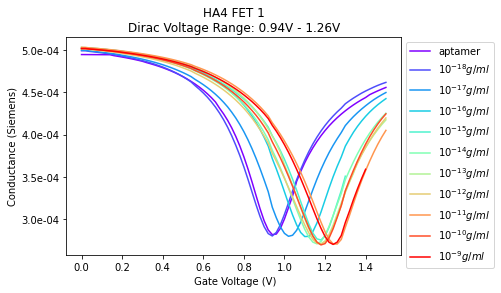

In [5]:
# plotting conductance vs gate voltage for single FET
device_number = 0
maxim = np.min(dataset.dirac_voltages[:,device_number])
minim = np.max(dataset.dirac_voltages[:,device_number])

x = [0.02*f for f in range(len(dataset.apt_conductances[device_number]))]
# cmap = plt.get_cmap('Blues')
cmap = plt.get_cmap('rainbow')
plt.plot(x, dataset.apt_conductances[device_number], color=cmap(0) , label='aptamer')

for j in range(dataset.num_concs):
    x = [0.02*f for f in range(len(dataset.conductances[j][device_number]))]
    y = dataset.conductances[j][device_number]
    plt.plot(x, y, color=cmap((j+1) / 10), label=rf'$10^{{{j-18}}} g/ml$')
plt.title(f'HA4 FET 1\nDirac Voltage Range: {maxim}V - {minim}V')
plt.xlabel(" Gate Voltage (V)")
plt.ylabel("Conductance (Siemens)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_e))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
plt.close()

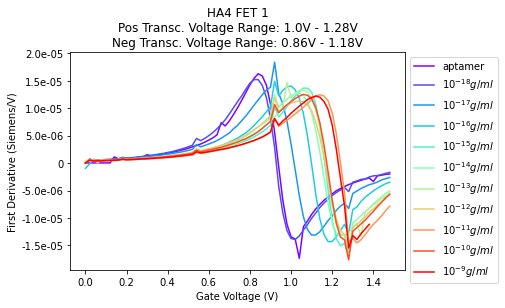

In [6]:
# plotting conductance derivative vs gate voltage for single FET

i = 0
pos_maxim = np.max(dataset.pos_transc_voltages[:,i])
pos_minim = np.min(dataset.pos_transc_voltages[:,i])
neg_maxim = np.max(dataset.neg_transc_voltages[:,i])
neg_minim = np.min(dataset.neg_transc_voltages[:,i])

cmap = plt.get_cmap('rainbow')
x = [0.02*f for f in range(len(dataset.apt_conductance_derivatives[device_number]))]
plt.plot(x, dataset.apt_conductance_derivatives[device_number], color=cmap(0) , label='aptamer')

# conductance derivative shifts
for j in range(dataset.num_concs):
    y = dataset.conductance_derivatives[j][i]
    x = [0.02*f for f in range(len(y))]
    plt.plot(x, y, color=cmap((j+1) / 10), label=rf'$10^{{{j-18}}} g/ml$')
plt.title(f'HA4 FET 1\nPos Transc. Voltage Range: {pos_minim}V - {pos_maxim}V\nNeg Transc. Voltage Range: {neg_minim}V - {neg_maxim}V')
plt.xlabel("Gate Voltage (V)")
plt.ylabel("First Derivative (Siemens/V)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_e))
plt.show()
plt.close()

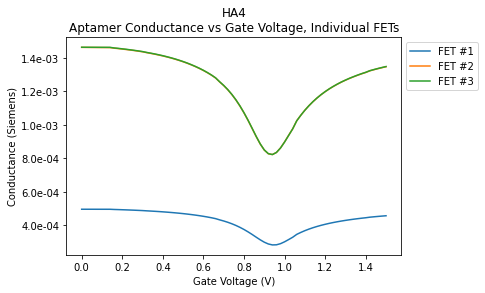

In [7]:
# plotting IV (GV) curve for aptamer data, all individual lines    

for dev_num in range(dataset.num_devices):
    y = dataset.apt_conductances[dev_num]
    x = [0.02*f for f in range(len(y))]
    plt.plot(x, y, label=f'FET #{dev_num+1}')
plt.title('HA4\nAptamer Conductance vs Gate Voltage, Individual FETs')
plt.xlabel("Gate Voltage (V)")
plt.ylabel("Conductance (Siemens)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_e))
plt.show()
plt.close()

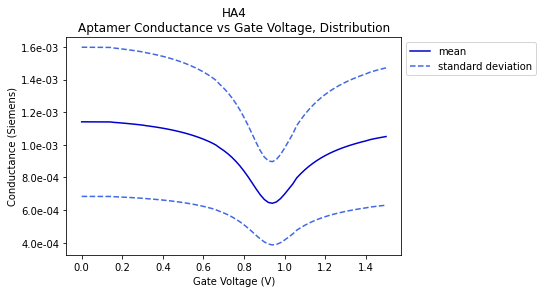

In [8]:
# plotting IV (GV) curve for aptamer data, the average, a single line with std devs
x = [0.02*f for f in range(len(dataset.apt_conductances[0]))]
y = []
std_dev = []
for v_idx in range(len(dataset.apt_conductances[0])):
    y.append(np.mean([dataset.apt_conductances[dev_num][v_idx] for dev_num in range(dataset.num_devices)]))
    std_dev.append(np.std([dataset.apt_conductances[dev_num][v_idx] for dev_num in range(dataset.num_devices)]))

plt.plot(x, y, label='mean', color='mediumblue')
plt.plot(x, [y[i]+std_dev[i] for i in range(len(y))], color='royalblue', linestyle='--')
plt.plot(x, [y[i]-std_dev[i] for i in range(len(y))], color='royalblue', linestyle='--', label='standard deviation')
    
plt.title('HA4\nAptamer Conductance vs Gate Voltage, Distribution')
plt.xlabel("Gate Voltage (V)")
plt.ylabel("Conductance (Siemens)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_e))
plt.show()
plt.close()

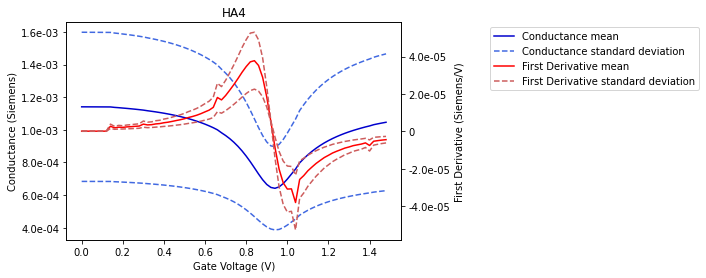

In [9]:
# plotting IV (GV) curve for aptamer data, the average, a single line with std devs
fig, ax1 = plt.subplots()
x = [0.02*f for f in range(len(dataset.apt_conductances[0]))]

y_cond = []
std_dev_cond = []
for v_idx in range(len(dataset.apt_conductances[0])):
    y_cond.append(np.mean([dataset.apt_conductances[dev_num][v_idx] for dev_num in range(dataset.num_devices)]))
    std_dev_cond.append(np.std([dataset.apt_conductances[dev_num][v_idx] for dev_num in range(dataset.num_devices)]))

y_transcond = []
std_dev_transcond = []
for v_idx in range(len(dataset.apt_conductance_derivatives[0])):
    y_transcond.append(np.mean([dataset.apt_conductance_derivatives[dev_num][v_idx] for dev_num in range(dataset.num_devices)]))
    std_dev_transcond.append(np.std([dataset.apt_conductance_derivatives[dev_num][v_idx] for dev_num in range(dataset.num_devices)]))

ax1.plot(x[:len(y_transcond)], y_cond[:len(y_transcond)], label='Conductance mean', color='mediumblue')
ax1.plot(x[:len(y_transcond)], [y_cond[i]+std_dev_cond[i] for i in range(len(y_cond))][:len(y_transcond)], color='royalblue', linestyle='--')
ax1.plot(x[:len(y_transcond)], [y_cond[i]-std_dev_cond[i] for i in range(len(y_cond))][:len(y_transcond)], color='royalblue', linestyle='--', label='Conductance standard deviation')
ax1.set_xlabel("Gate Voltage (V)")
ax1.set_ylabel("Conductance (Siemens)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_e))

ax2 = ax1.twinx()
ax2.plot(x[:len(y_transcond)], y_transcond, label='First Derivative mean', color='red')
ax2.plot(x[:len(y_transcond)], [y_transcond[i]+std_dev_transcond[i] for i in range(len(y_transcond))], color='indianred', linestyle='--')
ax2.plot(x[:len(y_transcond)], [y_transcond[i]-std_dev_transcond[i] for i in range(len(y_transcond))], color='indianred', linestyle='--', label='First Derivative standard deviation')
ax2.set_xlabel("Gate Voltage (V)")
ax2.set_ylabel("First Derivative (Siemens/V)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_e))

# Create a single legend with combined handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.25, 1))

plt.title('HA4')
plt.show()
plt.close()

76
76


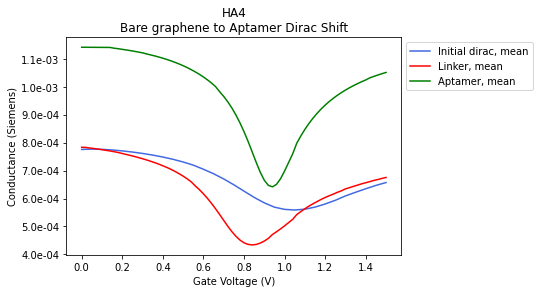

bare 1.05
linker 0.84
aptamer 0.94
bare -> linker, -0.21
linker -> aptamer, 0.1
bare -> aptamer, -0.11


In [10]:
# plotting IV (GV) curve for aptamer vs bare grapheen data using the average for each, a single line with std devs

# IV curve for initial dirac data
x_id = [0.05*f for f in range(len(dataset.id_conductances[0]))]
y_id = []
std_dev_id = []
for v_idx in range(len(dataset.id_conductances[0])):
    y_id.append(np.mean([dataset.id_conductances[dev_num][v_idx] for dev_num in range(dataset.num_devices)]))
    std_dev_id.append(np.std([dataset.id_conductances[dev_num][v_idx] for dev_num in range(dataset.num_devices)]))
plt.plot(x_id, y_id, label='Initial dirac, mean', color='royalblue')
# plt.plot(x_id, [y_id[i]+std_dev_id[i] for i in range(len(y_id))], color='limegreen', linestyle='--')
# plt.plot(x_id, [y_id[i]-std_dev_id[i] for i in range(len(y_id))], color='limegreen', linestyle='--', label='Bare graphene standard deviation')

# IV curve for linker data
x_linker = [0.02*f for f in range(len(dataset.linker_conductances[0]))]
print(len(dataset.linker_conductances[0]))
y_linker = []
std_dev_linker = []
for v_idx in range(len(dataset.linker_conductances[0])):
    y_linker.append(np.mean([dataset.linker_conductances[dev_num][v_idx] for dev_num in range(dataset.num_devices)]))
    std_dev_linker.append(np.std([dataset.linker_conductances[dev_num][v_idx] for dev_num in range(dataset.num_devices)]))
plt.plot(x_linker, y_linker, label='Linker, mean', color='red')
# plt.plot(x_linker, [y_linker[i]+std_dev_linker[i] for i in range(len(y_linker))], color='limegreen', linestyle='--')
# plt.plot(x_linker, [y_linker[i]-std_dev_linker[i] for i in range(len(y_linker))], color='limegreen', linestyle='--', label='Bare graphene standard deviation')

# IV curve for aptamer data
x_apt = [0.02*f for f in range(len(dataset.apt_conductances[0]))]
print(len(dataset.apt_conductances[0]))
y_apt = []
std_dev_apt = []
for v_idx in range(len(dataset.apt_conductances[0])):
    y_apt.append(np.mean([dataset.apt_conductances[dev_num][v_idx] for dev_num in range(dataset.num_devices)]))
    std_dev_apt.append(np.std([dataset.apt_conductances[dev_num][v_idx] for dev_num in range(dataset.num_devices)]))
plt.plot(x_apt, y_apt, label='Aptamer, mean', color='green')
# plt.plot(x_apt, [y_apt[i]+std_dev_apt[i] for i in range(len(y_apt))], color='royalblue', linestyle='--')
# plt.plot(x_apt, [y_apt[i]-std_dev_apt[i] for i in range(len(y_apt))], color='royalblue', linestyle='--', label='Aptamer standard deviation')

plt.title('HA4\nBare graphene to Aptamer Dirac Shift')
plt.xlabel("Gate Voltage (V)")
plt.ylabel("Conductance (Siemens)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_e))
plt.show()
plt.close()

id_avg_dirac, linker_avg_dirac, apt_avg_dirac = round(np.mean(list(dataset.id_dirac_voltages.values())), 3), round(np.mean(list(dataset.linker_dirac_voltages.values())), 3), round(np.mean(list(dataset.apt_dirac_voltages.values())), 3)

print('bare', id_avg_dirac)
print('linker', linker_avg_dirac)
print('aptamer', apt_avg_dirac)
print(f'bare -> linker, {round(linker_avg_dirac - id_avg_dirac, 3)}')
print(f'linker -> aptamer, {round(apt_avg_dirac - linker_avg_dirac, 3)}')
print(f'bare -> aptamer, {round(apt_avg_dirac - id_avg_dirac, 3)}')